# Finalny model

## Pakiety

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score,calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

/home/piotr/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Funkcje pomocnicze

In [2]:
def score_kmeans(df, cluster_num_vector):
    """
    Funkcja zwraca miary wcss odpowiadające wartością k,
    działa dla modelu k-średnich.
    """
    scores = []
    for k in cluster_num_vector:
        md = KMeans(n_clusters = k)
        md.fit(df)
        scr = md.score(df)
        scores.append(-scr)
    return(scores)

def find_best_k(df, k_vec):
    scr = score_kmeans(df, k_vec)
    plot_k_scores(k_vec, scr, "k", "wcss", "Metoda łokcia")
    
    
def plot_scor(df,metric,title):
    scors = []
    for k in range(3,8):
        kmean = KMeans(k)
        label = kmean.fit_predict(df)
        scor = metric(df,label)
        scors.append(scor)
    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(3, 8), scors,marker='h')
    plt.xticks(np.arange(3,8,1))
    plt.grid(True)
    plt.title(title)
    plt.xlabel('Number of clusters')

def plot_k_scores(k_vec, result, xlab, ylab, title):
    """Wizualizacja dowolnej miary względem dowolnego wektora k."""
    plt.plot(k_vec, result, marker='h')
    plt.xticks(np.arange(min(k_vec), max(k_vec)+1, 2))
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()
    
def scatter_3D(df, lab, title):
    """Wykres 3D z etykietami klastrów"""
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    x = df.iloc[:, 0]
    y = df.iloc[:, 1]
    z = df.iloc[:, 2]
    ax.scatter3D(x, y, z, c = lab, cmap="Dark2")
    plt.title(title)
    ax.set_xlabel('X direction')
    ax.set_ylabel('Y direction')
    ax.set_zlabel('Z direction')

def compare_labels(org, clust, title):
    x = pd.DataFrame()
    x['org'] = org
    x['cluster'] = clust
    r = x.groupby(['org', 'cluster']).size().to_frame()
    r.reset_index(inplace=True)
    r.columns = ['org', 'cluster', 'count']
    sns.catplot(data=r , x='org', y='count', hue='cluster', kind='bar')
    plt.xlabel("Oryginalna aktywność")
    plt.title(title)
    
def abs_dist(row, df):
    rows = [0,1,2]
    rows.pop(row)
    distances = []
    for i in range(len(df.columns)):
        x1 = np.abs(df.iloc[row, i] - df.iloc[rows[0], i])
        x2 = np.abs(df.iloc[row, i] - df.iloc[rows[1], i])
        dist = x1 + x2
        distances.append(dist)
    return(np.argpartition(distances, -5)[-5:])

def hi_var(labels, data_var, row, title):
    data_var['klaster'] = labels
    data_gr = data_var.groupby('klaster').mean()
    best = abs_dist(row, data_gr)
    df_vis = data_gr.iloc[:,best]
    df_vis.columns = best+1
    np.transpose(df_vis).plot(kind='bar')
    plt.title(title)
    plt.ylabel('Średnia wartości zmiennej')
    plt.xlabel('Zmienna')
    print("Wróżniające zmienne:")
    print("\n".join(data_var.columns[best]))

## Wczytanie danych

In [3]:

labels = pd.read_fwf("./UCI_HAR_Dataset/features.txt",header=None)
X_train = pd.read_fwf("./UCI_HAR_Dataset/train/X_train.txt",header=None)
X_train.columns = labels


y_train = pd.read_fwf("./UCI_HAR_Dataset/train/y_train.txt",header=None)
y_train = pd.Series(y_train[0])

X_test = pd.read_fwf("./UCI_HAR_Dataset/test/X_test.txt",header=None)
X_test.columns = labels

y_test = pd.read_fwf("./UCI_HAR_Dataset/test/y_test.txt",header=None)
y_test = pd.Series(y_test[0])

data = pd.concat([X_train,X_test])
y = pd.concat([y_train,y_test])


In [4]:
proper = list()
for i in range(len(data.columns)):
    proper.append(data.columns[i][0])  
data.columns = proper

data.reset_index(inplace=True,drop=True)

## Wnioski z poprzednich etapów

Poprzednio udało się nam sprawdzić, iż do naszego problemu najlepiej pasuje użycie PCA w celu zmniejszenia wymiarowości danych. Teraz zajmiemy się odpowiednim doborem modelu oraz jego parametrów oraz analizą wyników. 

### PCA

In [5]:
pca = PCA(n_components=11)
df_pca = pca.fit_transform(data)

## Dobór ilości klastrów

Aby móc pracować większość algorytmów klasteryzacji wymaga jasno określonej ilości klastrów. Aby ostatecznie zdecydować jaka liczba klastrów będzie najlepsze dla naszego problemu zdecydowaliśmy się użyć metody łokcia, metody silhouette oraz metody Calińskiego-Harabasza. Warto przypomnieć, że obserwacje oryginalnie były przypisane do 6 kategorii. Nie chcieliśmy jednak korzystać z tej informacji, aby projekt w pełni oddawał istotę klasteryzacji. 

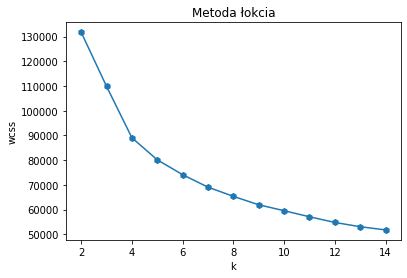

In [6]:
find_best_k(df_pca,range(2,15))

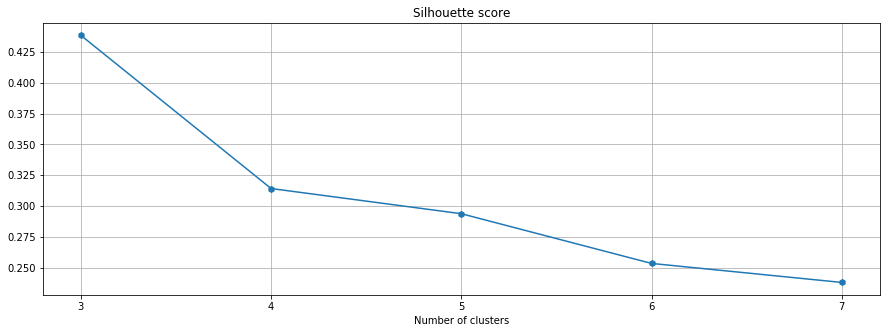

In [8]:
plot_scor(df_pca,silhouette_score,'Silhouette score')

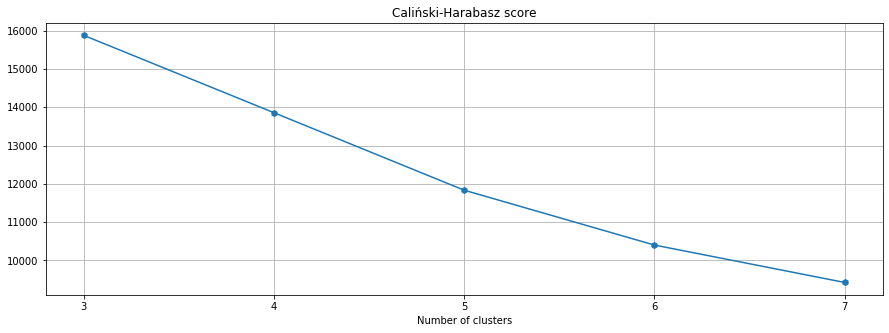

In [7]:
plot_scor(df_pca,calinski_harabasz_score,'Caliński-Harabasz score')

Wybór liczby klastrów przez cały czas pracy nad projektem był trudnym zadaniem. Widzimy że metoda łokcia nie sprawdza się, gdyż nie możemy zaobserwować wyraźnego punktu przegięcia. Z dwóch pozostałych metryk jednoznacznie wynika, że optymalna liczba klastrów to 3. Bardzo ciężko o jednoznaczny wybór, ale zdecydowaliśmy się wybrać k=3.

## Modelowanie

W celu uzyskania jak najlepszych wyników użyjemy trzech różnych modeli. W trakcie inżynierii cech najlepsze wyniki dawało działanie na 3 klastrach, jako że algorytmom łatwiej było podzielić aktywności na te wymagające dużo ruchu oraz bardziej statyczne. Aby spróbować poprawić wyniki zdecydowaliśmy się zastąpić poprzednio używany algorytm Birch na algorytm DBSCAN. Skorzystamy więc z:
- KMeans
- DBSCAN
- AgglomerativeClustering

Warto będzie zwrócić uwagę na sprawowanie się algorytmu DBSCAN, z racji tego że cechuje się on innym działaniem niż pozostałe dwa. Nie wymaga on podania dokładnej ilości klastrów do pracy.

In [15]:
kmean = KMeans(3)
labels_kmean = kmean.fit_predict(df_pca)

In [9]:
agg = AgglomerativeClustering(3)
labels_agg = agg.fit_predict(df_pca)

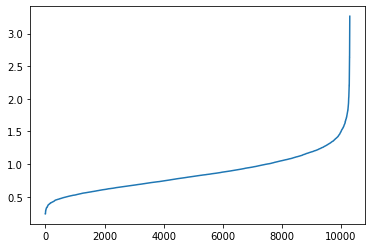

In [17]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_pca)
distances, indices = nbrs.kneighbors(df_pca)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Aby dobrać odpowiedni parametr eps dla algorytmu DBSCAN użyjemy metody opisanej tutaj: https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf. Mówiąc ogólnie, znajdujemy odpowiednią wartość dla  epsilona, obliczając odległość do najbliższych n punktów dla każdego punktu, sortując i rysując wyniki. Następnie sprawdzamy, gdzie wzrost jest największy (podobnie jak w metodzie łokcia).  
Na podstawie wykresu możemy wytypować eps=1.5.

In [18]:
for i in range(1,20):
    dbs = DBSCAN(1.5,i)
    labels_dbs = dbs.fit_predict(df_pca)
    score = silhouette_score(df_pca,labels_dbs)
    print(f'Ilość sąsiadów = {i}, wynik = {round(score,2)}')

Ilość sąsiadów = 1, wynik = -0.4
Ilość sąsiadów = 2, wynik = -0.2
Ilość sąsiadów = 3, wynik = -0.08
Ilość sąsiadów = 4, wynik = 0.02
Ilość sąsiadów = 5, wynik = 0.04
Ilość sąsiadów = 6, wynik = 0.31
Ilość sąsiadów = 7, wynik = 0.38
Ilość sąsiadów = 8, wynik = 0.25
Ilość sąsiadów = 9, wynik = 0.3
Ilość sąsiadów = 10, wynik = 0.27
Ilość sąsiadów = 11, wynik = 0.31
Ilość sąsiadów = 12, wynik = 0.3
Ilość sąsiadów = 13, wynik = 0.29
Ilość sąsiadów = 14, wynik = 0.41
Ilość sąsiadów = 15, wynik = 0.41
Ilość sąsiadów = 16, wynik = 0.31
Ilość sąsiadów = 17, wynik = 0.26
Ilość sąsiadów = 18, wynik = 0.26
Ilość sąsiadów = 19, wynik = 0.24


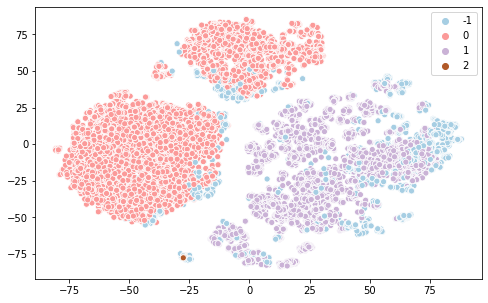

In [19]:
dbs = DBSCAN(1.5,14)
labels_dbs = dbs.fit_predict(df_pca)
score = silhouette_score(df_pca,labels_dbs)

pca = PCA(n_components=0.9, random_state=3)
pca_data = pca.fit_transform(data)

tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(pca_data)

fig = plt.gcf()
fig.set_size_inches(8,5)
sns.scatterplot(tsne_transformed[:,0],tsne_transformed[:,1],hue=labels_dbs,palette='Paired')

Klastry zaproponowane przez DBSCAN wyglądają średnio sensownie.

In [32]:
np.unique(labels_dbs)

array([-1,  0,  1,  2])

DBSCAN również zaproponował 3 klastry, pomimo że wprost nie definiuje się dla niego tej wartości. Etykieta -1 oznacza obserwacje określone jako szum.

## Wizualizacja klasteryzacji na oryginalnych zmiennych

Poniżej przedstawiamy wizualizację skupień zaprezentowaną na wykresach, które podczas EDA najczytelniej obrazowały właściwe 6 typów aktywności.

In [28]:
fBodyGyro_entropy = data[['446 fBodyGyro-entropy()-X', '447 fBodyGyro-entropy()-Y', '448 fBodyGyro-entropy()-Z']]

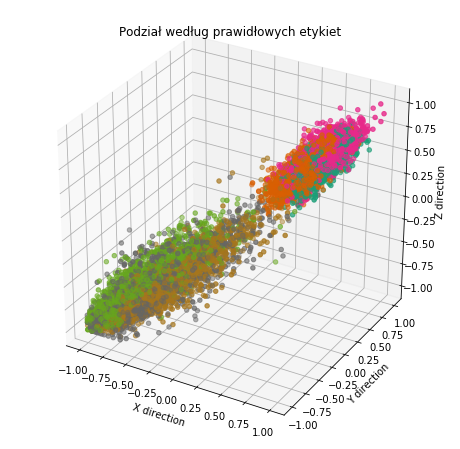

In [33]:
scatter_3D(fBodyGyro_entropy, y, "Podział według prawidłowych etykiet")

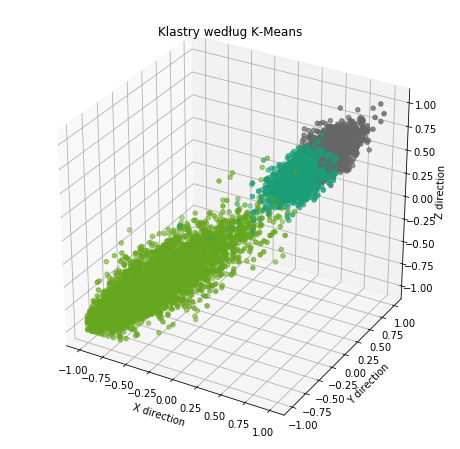

In [29]:
scatter_3D(fBodyGyro_entropy, labels_kmean, "Klastry według K-Means")

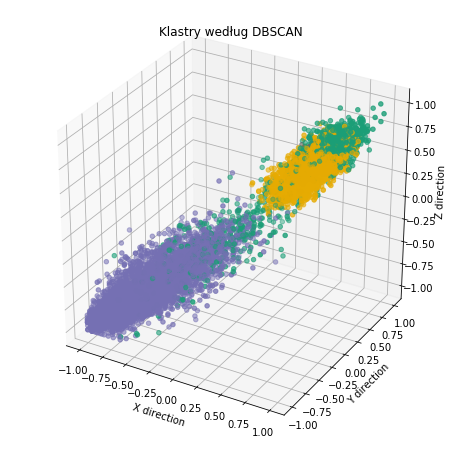

In [31]:
scatter_3D(fBodyGyro_entropy, labels_dbs, "Klastry według DBSCAN")

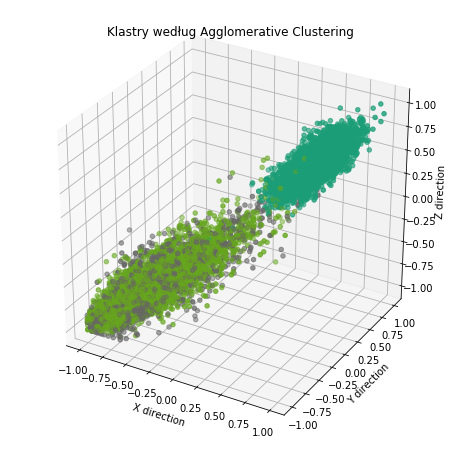

In [30]:
scatter_3D(fBodyGyro_entropy, labels_agg, "Klastry według Agglomerative Clustering")

Na podstawie powyższych wizualizacji możemy nabrać więcej intuicji o tym jak skupienia zaproponowane przez algorytmy prezentują się na oryginalnych zmiennych ze zbioru. Widzimy, że podobne podziały przyniosły modele DBSCAN i K-Means. Agglomerative Clustering potencjalnie uchwycił nieco inne zależności w danych, ponieważ schemat klastrów jest wyraźnie inny od tego uzyskanego dwoma wcześniej wspomnianymi algorytmami. 

## Porównanie do oryginalnych etykiet

In [211]:
labels = {1: "walking", 2: "walking \n upstairs", 
          3: "walking \n downstairs", 4: "sitting", 
          5: "standing", 6: "laying"}
y_str = y.replace(labels)

Podczas budowania modeli unikaliśmy przez cały czas używania i sugerowania się oryginalnymi etykietami aktywności. Użyjemy ich dopiero teraz do lepszego zrozumienia rezultatów klasteryzacji. Poniżej możemy porównać jak aktywności według wzorcowych oznaczeń, rozkładają się między otrzmane klastry .

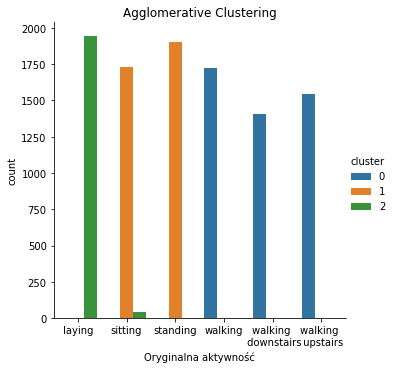

In [212]:
compare_labels(y_str, labels_agg, "Agglomerative Clustering")

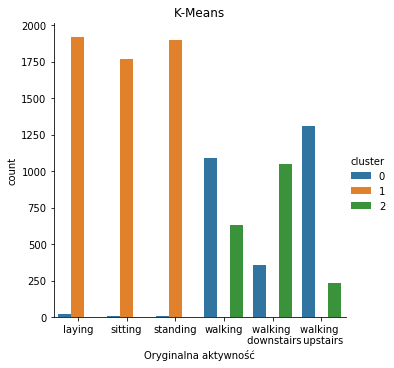

In [214]:
compare_labels(y_str, labels_kmean, "K-Means")

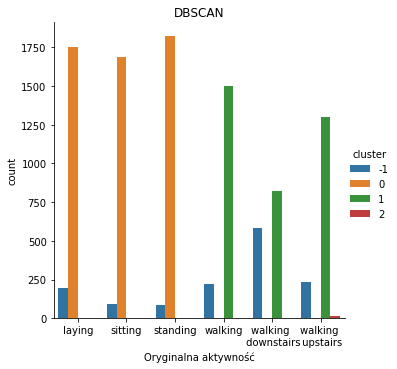

In [216]:
compare_labels(y_str, labels_dbs, "DBSCAN")

Ewidentnie możemy stwierdzić, że najbardziej wartościowe rezultaty ma model Agglomerative Clustering. Obserwacje są rozdielone do klastrów jednoznacznie. W przeciwieństwie do dwóch pozostałych modeli, które nie były w stanie rozróżnić klarownie aktywności typu 'walking'.

## Analiza zróżnicowania klastrów

Dla rezultatu modelu Agglomerative Clustering chcielibyśmy znaleźć zmienne, które wyróżniają poszczególne klastry. Porównujemy różnice średniej  
z wartości każdej ze zmiennych między klastrami.

Wróżniające zmienne:
511 fBodyAccMag-entropy()
235 tBodyAccJerkMag-entropy()
368 fBodyAccJerk-entropy()-Y
288 fBodyAcc-entropy()-X
367 fBodyAccJerk-entropy()-X


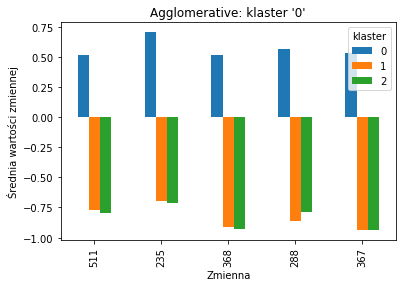

In [29]:
data_var = data.copy()

hi_var(labels_agg, data_var, 0, "Agglomerative: klaster '0'")

Wróżniające zmienne:
235 tBodyAccJerkMag-entropy()
368 fBodyAccJerk-entropy()-Y
57 tGravityAcc-energy()-X
367 fBodyAccJerk-entropy()-X
288 fBodyAcc-entropy()-X


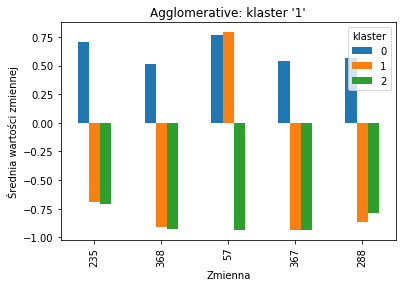

In [30]:
hi_var(labels_agg, data_var, 1, "Agglomerative: klaster '1'")

Wróżniające zmienne:
559 angle(X,gravityMean)
53 tGravityAcc-min()-X
57 tGravityAcc-energy()-X
50 tGravityAcc-max()-X
41 tGravityAcc-mean()-X


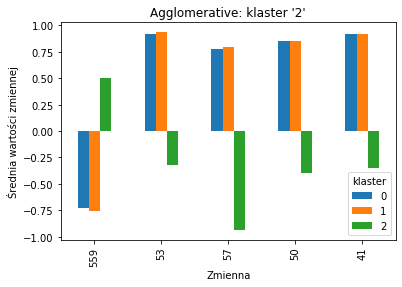

In [31]:
hi_var(labels_agg, data_var, 2, "Agglomerative: klaster '2'")

Podanie dokładnej interpretacji dla zmiennych wyróżniających dany klaster jest trudne ze względu na charakterystykę zmiennych w naszym zbiorze. Na pewno uwagę przykuwają:
- klaster '2' (laying): zmienne z grupy GravityAcc przeciwne wartości do pozostałych klastrów
- klaster '0' oraz '1' (walking oraz sitting/standing): zmienne z grupy BodyAcc mają przeciwne wartości względem obu tych klastrów.

## Charakterystyka klastrów

In [33]:
from xgboost import XGBClassifier
from xgboost import plot_importance

In [62]:
def f_importance(labels, df, cluster):
    labels = np.array(labels)
    labels[labels!=cluster] = -1
    xgb = XGBClassifier()
    xgb.fit(data, labels)
    plot_importance(xgb, max_num_features=5)

Użyjemy XGBoost badając znaczenie zmiennych dla tego modelu. Definiujemy problem klasyfikacji o zmiennej celu 'wybrany klaster vs pozostałe'. Pozwoli to na uzyskanie zmiennych charakterystycznych dla danego klastra z punktu widzenia algorytmu XGB.

### Klaster '0' - walking

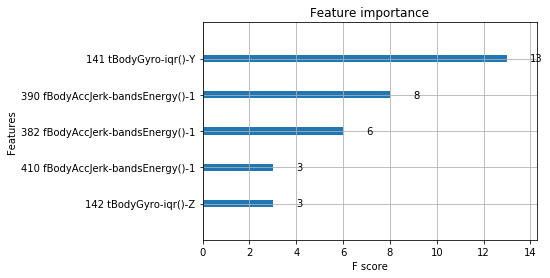

In [63]:
f_importance(labels_agg, data, 0)

### Klaster '1' - sitting/standing

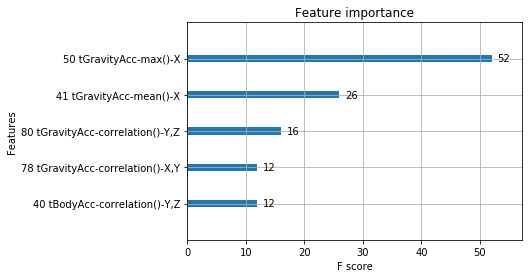

In [65]:
f_importance(labels_agg, data, 1)

### Klaster '2' - laying

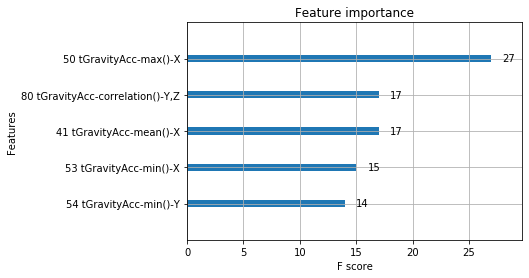

In [66]:
f_importance(labels_agg, data, 2)

Z powodu charakterystyki zmiennych trudno o interpretację dlaczego konkretna zmienna mogła mieć tak duże znaczenie. Możemy natomiast zauważyć, że potwierdzają się poprzednie obserwacje klastra 'laying', gdzie kluczowe zmienne pochodzą z grupy GravityAcc. W przypadku klastra 'siiting/standing' warta uwagi jest zmienna 'GravityAcc-max()X', gdyż znacząco wyróżnia się od pozostałych. Dla klastra 'walking' interesujące jest, że zmienne są z pmiaru bandsEnergy(), którego wcześniej nigdzie nie zobserwowaliśmy jako potencjalnie istotnego. 

# Podsumowanie
**Wybrany model**: AgglomerativeClustering  
**Liczba klastrów**: 3  
**Interpretacja klastrów**: laying - sitting/standing - walking/upstairs/downstairs  
  
Budując modele przestrzegaliśmy zasady nie sugerowania się oryginalnymi etykietami. Według wzorców postępowania wytypowaliśmy liczbę klastrów równą 3. Zredukowaliśmy wymiarowość danych przy użyciu metody PCA, która przyniosła najlepsze rezultaty z kilku badanych. Po testach kilku modeli za najlepszy wybraliśmy AgglomerativeClustering. Porównaliśmy wynki klasteryzacji do oryginalnych etykiet. Model dokonał podziału skupień rozróżniając grupy aktywności na statyczne, dynamiczne i pozycję leżącą. Udało się znaleźć zmienne charakteryzujące poszczególne skupienia.